# The heat equation

This notebook will show you how to solve a transient problem using DOLFINx, and highlight differences between `dolfin` and `dolfinx`.
We start by looking at the structure of DOLFINx:

Relevant DOLFINx modules
- `dolfinx.mesh`: Classes and functions related to the computational domain
- `dolfinx.fem`: Finite element method functionality
- `dolfinx.io`: Input/Output (read/write) functionality
- `dolfinx.plot`: Convenience functions for exporting plotting data

In [1]:
from dolfinx import mesh, fem, io, plot

## Creating a distributed computational domain (mesh)

To create a simple computational domain in DOLFINx, we use the mesh generation utils in `dolfinx.mesh`. Here we have tools to build rectangles of triangular/quadrilateral and boxes of tetrahedral/hexahedral elements. We start by creating a rectangle spanning [0,0]X[10,3], with 100 and 20 elements in each direction respectively.

In [2]:
from mpi4py import MPI
length = 10
width = 3
Nx = 100
Ny = 20
domain = mesh.create_rectangle(MPI.COMM_WORLD, 
                               [[0.,0.],[length, width]],
                               [Nx, Ny], 
                               cell_type=mesh.CellType.quadrilateral)

As opposed to DOLFIN, we work on simply python structures (nested listes/numpy arrays).
We also note that we have to send in a communicator. This is because we want the user to be aware of how the mesh is distributed when running in parallel. 
If we would use the communicator `MPI.COMM_SELF`, each process initialized when running the script would have a mesh local to its process.

## Creating a mesh on each process

In [3]:
local_domain =  mesh.create_rectangle(MPI.COMM_SELF,
                               [[0.,0.],[length, width]],
                               [Nx, Ny], 
                               cell_type=mesh.CellType.quadrilateral)

## Setting up a variational problem

We will solve the heat equation, with a backward Euler time stepping scheme, i.e.

$$
\begin{align*}
\frac{u_{n+1}-u_n}{\Delta t} - \nabla \cdot (\mu  \nabla u_{n+1}) &= f(x,t_{n+1}) \qquad \text{in } \Omega,\\
u &= u_D(x,t_{n+1}) \qquad \text{on } \partial\Omega_D,\\
\mu\frac{\partial u_{n+1}}{\partial n} &=0 \qquad \text{on } \partial\Omega_N
\end{align*}
$$ 
with $u_D = \sin(t)\cos(y)$, $f=0$.

We start by defining the function space, the corresponding test and trial functions, as well as material and temporal parameters. We note that we use explicit imports from ufl to create the test and trial functions, to avoid confusion as to where they originate from. DOLFINx and UFL supports both real and complex valued functions. However, to be able to use the PETSc linear algebra backend, which only supports a single floating type at compilation, we need to use appropriate scalar types in our variational form. This ensures that we generate consistent matrices/vectors

In [4]:
from ufl import TestFunction, TrialFunction, dx, grad, inner, system
from petsc4py import PETSc
V = fem.FunctionSpace(domain, ("Lagrange", 1))
u = TrialFunction(V)
v = TestFunction(V)
un = fem.Function(V)
f = fem.Constant(domain, PETSc.ScalarType(0.0))
mu = fem.Constant(domain, PETSc.ScalarType(0.1))
dt = fem.Constant(domain, PETSc.ScalarType(0.01))

The variational form can be written in UFL syntax, as done in old DOLFIN:

In [5]:
F = inner(u - un, v) * dx + mu * inner(grad(u), grad(v)) * dx \
  - inner(f, v) * dx
(a, L) = system(F)

## Creating Dirichlet boundary conditions

To give the user freedom to set boundary conditions on single degrees of freedom, the `dolfinx.fem.dirichletbc` takes in the list of degrees of freedom as input. These can be obtained in many ways, but we supply a few convenience functions, such as `dolfinx.fem.locate_dofs_topological` and `dolfinx.locate_dofs_geometrical`.
Locating dofs topologically is generally advised, as certain finite elements dofs do not have a geometrical coordinate (Nedelec, RT etc). DOLFINx also has convenicence functions to obtain a list of all boundary facets.

In [6]:
import numpy as np
tdim = domain.topology.dim
def dirichlet_facets(x):
    return np.isclose(x[0], length)

bc_facets = mesh.locate_entities_boundary(domain, tdim-1, dirichlet_facets)
print(type(bc_facets))

<class 'numpy.ndarray'>


In [7]:
bndry_dofs = fem.locate_dofs_topological(V, tdim-1, bc_facets)
print(type(bndry_dofs))

<class 'numpy.ndarray'>


### Creating a time dependent boundary condition

There are many ways of creating boundary conditions. In this example, we will create a time and spatially dependent function `uD(x,t)`. To do this we will use a function working on numpy arrays, where the input `x` is a 2D vector where each column corresponds to a coordinate (x,y,z).

In [8]:
def uD_function(t):
    return lambda x: np.sin(t) * np.cos(x[1])

uD = fem.Function(V)
t = 0
uD.interpolate(uD_function(t))

In [9]:
bcs = [fem.dirichletbc(uD, bndry_dofs)]

## Setting up a time dependent solver

For the linear solver, we would like to create the matrix and vector used for the solving at each time step.
As the matrix is time-indepentent, we can assemble this once outside the temporal loop.

In [10]:
a_form = fem.form(a)
A = fem.petsc.assemble_matrix(a_form, bcs=bcs)
A.assemble()

Next, we can generate the integration kernel for the right hand side, and create the rhs vector `b` that we will assemble into at each time step

In [11]:
rhs_form = fem.form(L)
b = fem.petsc.create_vector(rhs_form)

We next create the PETSc KSP solver, and set it to solve it with a direct solver (LU).

In [12]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

## Solving a time dependent problem

We are now ready to solve the time dependent problem. At each time step, we need to:
1. Update the time dependent boundary condition and source
2. Reassemble the right hand side vector `b`
3. Apply boundary conditions to `b`
4. Solve linear problem `Au = b`
5. Update previous time step, `un = u`

In [13]:
T = np.pi
uh = fem.Function(V)
vtx = io.VTXWriter(domain.comm, "uh.bp", [uh])
while t < T:
    # Update boundary condition
    t += dt.value
    uD.interpolate(uD_function(t))
    
    # Assemble RHS
    with b.localForm() as loc:
        loc.set(0)
    fem.petsc.assemble_vector(b, rhs_form)
    
    # Apply boundary condition
    fem.petsc.apply_lifting(b, [a_form], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,
                  mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bcs)

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()
    
    # Update un
    un.x.array[:] = uh.x.array
    vtx.write(t)
vtx.close()

# Plotting the solution

We plot the solution using [pyvista](https://github.com/pyvista/pyvista), which supports plotting of VTK structures. 
We create a VTK grid for plotting the solution by using `dolfinx.plot.create_vtk_mesh`, and sending in the function space `V`. The function space has to be continuous or discontinuous Lagrange space.

In [14]:
import pyvista
topology, cells, geometry = plot.create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cells, geometry)

We can attach the data from the degrees of freedom to the mesh

In [15]:
grid.point_data["uh"] = uh.x.array.real

In [16]:
pyvista.start_xvfb(0.5) # Start virtual framebuffer for plotting
sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
            position_x=0.1, position_y=0.8, width=0.8, height=0.1)

In [17]:
plotter = pyvista.Plotter()
renderer = plotter.add_mesh(grid, show_edges=True,
                            scalar_bar_args=sargs)

In [18]:
# Settings for presentation mode
plotter.view_xy()
plotter.camera.zoom(1.3)

In [19]:
img = plotter.screenshot("uh.png",
                         transparent_background=True,
                         window_size=(1000,1000))

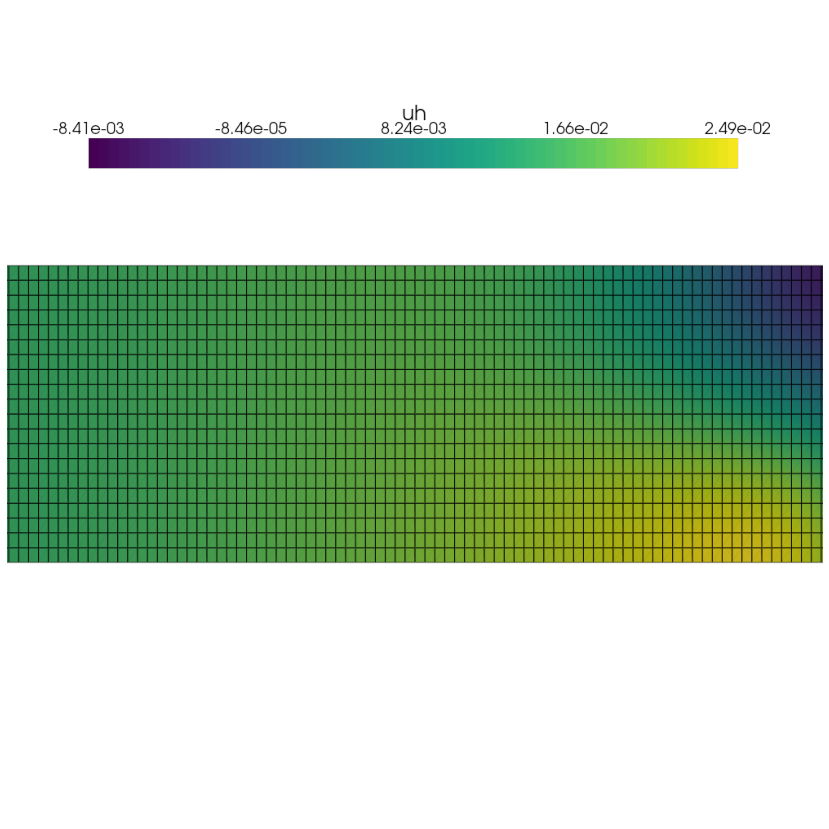

In [20]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.gcf().set_size_inches(15,15)
fig = plt.imshow(img)